# Proyecto

## Práctica 3: clustering

#### 1.- Seleccionar el número de clusters para K-means de acuerdo con los procedimientos recogidos en el notebook https://formacion.uam.es/mod/resource/view.php?id=75517.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns

#### Carga de datos
Se realiza la carga de los datos con los que se va a trabajar en el proyecto, que son los datos del dataset de "Bike-Sharing-Dataset".
Este dataset tiene como objetivo el predecir el uso diario y horario de un sistema de alquiler de bicicletas basándose en datos climatológicos, día de la semana, temporada, etc. El dataset incluye dos años de uso de bicicletas del sistema público de Washington DC.

In [4]:
# carga de datos del fichero horario original
df_bike = pd.read_csv('df_bike_final.csv', sep=',')
df_bike = df_bike.iloc[:,1:]

print("num_rows: %d\tColumnas: %d\n" % (df_bike.shape[0], df_bike.shape[1]) )
print("Columnas:\n", list(df_bike.columns))

num_rows: 17379	Columnas: 15

Columnas:
 ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'casual', 'cnt', 'season_weather', 'day']


In [5]:
# Lo primero que vamos a hacer es recuperar la variable registered a partir de restar cnt y casual
def f(row):
    return (row['cnt']-row['casual'])

df_bike['registered'] = df_bike.apply(f, axis=1)

In [6]:
# Se observa que el valor máximo de 'cnt' es cercano a 1000, así que vamos a formar una nueva variable que cree a 
# partir de 'cnt' 4 clases distintas según intervalos de valores.
def f(row):
    if row["cnt"] < 250:
        return 0
    elif row["cnt"] >= 250 and row["cnt"] < 500:
        return 1
    elif row["cnt"] >= 500 and row["cnt"] < 750:
        return 2  
    elif row["cnt"] >= 750 and row["cnt"] < 1000:
        return 3
    print(row)

df_bike['cnt_class'] = df_bike.apply(f, axis=1)

In [7]:
df_bike.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,registered,cnt_class
0,1,0,1,0,0,6,0,1,0.24,0.81,0.0,3,16,1,1,13.0,0
1,1,0,1,1,0,6,0,1,0.22,0.80,0.0,8,40,1,1,32.0,0
2,1,0,1,2,0,6,0,1,0.22,0.80,0.0,5,32,1,1,27.0,0
3,1,0,1,3,0,6,0,1,0.24,0.75,0.0,3,13,1,1,10.0,0
4,1,0,1,4,0,6,0,1,0.24,0.75,0.0,0,1,1,1,1.0,0


In [8]:
# dividimos variable target y predictoras. La variable target sería la cnt_class
vars_bike = list(df_bike.columns[:-1])
target_bike = df_bike.columns[-1]
print(vars_bike)
print(target_bike)

['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'casual', 'cnt', 'season_weather', 'day', 'registered']
cnt_class


In [9]:
# ver el número de registros para cada valor de la clase
pd.value_counts(df_bike['cnt_class'])

0    12287
1     3805
2     1071
3      216
Name: cnt_class, dtype: int64

In [10]:
df_bike_vars = df_bike[vars_bike]
df_bike_vars.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,registered
0,1,0,1,0,0,6,0,1,0.24,0.81,0.0,3,16,1,1,13.0
1,1,0,1,1,0,6,0,1,0.22,0.80,0.0,8,40,1,1,32.0
2,1,0,1,2,0,6,0,1,0.22,0.80,0.0,5,32,1,1,27.0
3,1,0,1,3,0,6,0,1,0.24,0.75,0.0,3,13,1,1,10.0
4,1,0,1,4,0,6,0,1,0.24,0.75,0.0,0,1,1,1,1.0


In [11]:
df_bike_target = df_bike[target_bike]
df_bike_target.head()

0    0
1    0
2    0
3    0
4    0
Name: cnt_class, dtype: int64

In [12]:
LOOPS = 20
MAX_ITERATIONS = 30
INITIALIZE_CLUSTERS = 'k-means++'
CONVERGENCE_TOLERANCE = 0.001
NUM_THREADS = 8

x = df_bike_vars
y = df_bike_target

**Una primera opción para seleccionar el número de clusters se basa en el cómputo de la inercia de cada uno de los clusters. Se prueba con distintos candidatos de número de cluster y se calcula la inercia global**

Ese inercia no es sino el valor medio de la varianza de cada cluster respecto a su centroide. 

In [14]:
def plot_results(inertials):
    x, y = zip(*[inertia for inertia in inertials])
    plt.plot(x, y, 'ro-', markersize=8, lw=2)
    plt.grid(True)
    plt.xlabel('Num Clusters')
    plt.ylabel('Inertia')
    plt.show()
    
def select_clusters(points, loops, max_iterations, init_cluster, tolerance,
                    num_threads):
    
    inertia_clusters = list()

    for i in range(1, loops + 1, 1):
        # Creamos el objeto Kmeans
        kmeans = KMeans(n_clusters=i, max_iter=max_iterations,
                        init=init_cluster, tol=tolerance, n_jobs=num_threads)

        # Calculamos Kmeans
        kmeans.fit(points)

        # Obtenemos la inercia
        inertia_clusters.append([i, kmeans.inertia_])

    plot_results(inertia_clusters)

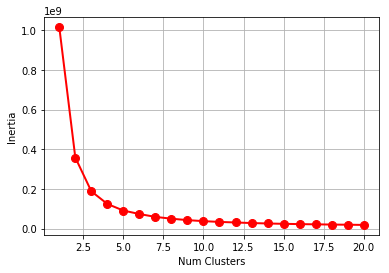

In [15]:
select_clusters(x, LOOPS, MAX_ITERATIONS, INITIALIZE_CLUSTERS, CONVERGENCE_TOLERANCE, NUM_THREADS)

**Los dendrogramas también nos pueden ser de ayuda a la hora de determinar posibles candidatos para el número de clusters**

In [20]:
def plot_dendrogram(points):
    # calcula la distancia entre puntos o grupos de puntos
    Z = linkage(points, metric='euclidean', method='ward')

    plt.title('Dendrogram')
    plt.xlabel('Points')
    plt.ylabel('Euclidean Distance')

    # genera el dendograma
    dendrogram(
        Z,
        truncate_mode='lastp',
        p=30,
        leaf_rotation=90.,
        leaf_font_size=12.,
        show_contracted=True
    )

    plt.show()

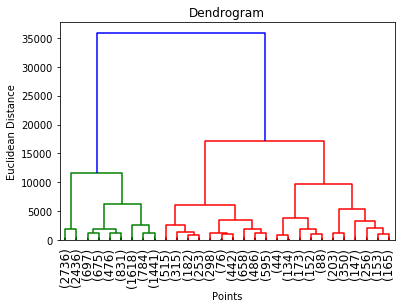

In [21]:
plot_dendrogram(x)

**Finalmente, se puede medir la distancia existente entre clusters. Se buscará el valor de cluster que maximiza la distancia inter-cluster**.

Aquí nos apoyamos de nuevo en el dendrograma, pues nos permite medir en cada nivel la distancia que existen entre las diversas ramas. En cada uno de los niveles nos quedamos con las últimas 10 distancias.

In [22]:
def plot_gap(points):    
    # Calculamos las distancias entre los puntos
    Z = linkage(points, metric='euclidean', method='ward')

    # Nos quedamos con las últimas 10 distancias. Las distancias están en la columna 2 (tercera columna) de Z
    last = Z[-10:, 2]
    
    num_clusters = np.arange(1, len(last) + 1)

    # Determinados el Gap
    gap = np.diff(last, n=2)  # Computamos la derivada segunda
    plt.plot(num_clusters[:-2] + 1, gap[::-1], 'ro-', markersize=8, lw=2)
    plt.show()

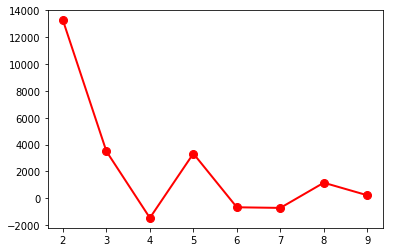

In [23]:
plot_gap(x)

#### Comentarios
Se han utilizado tres técnicas para intentar obtener el número adecuado de clusters: el uso del dendrograma, la técnica de elbow y la técnica gap de distancia máxima entre clusters. Vamos a proceder a analizar los resultados obtenidos en cada una de ellas y comentaremos la interpretación que hemos hecho de cada una de ellas:

   - Dendrograma: A través de esta técnica podemos ver como claramente tenemos dos grupos los cuales están ramificados a través de la agrupación definida con la línea azul. Si nos fijamos la distancia horizontalmente entre el top azul que está en 35.000 y el grupo rojo y verde, que están en torno a 12.000 y 18.000, es muy grande es por eso que consideramos según esta interpretación que sería mejor tener dos clusters, pues la distancia entre el cluster rojo y el verde es menor.
   
   
   - Elbow: Para este caso se nos hace más complicado determinar el número de clusters que deberíamos seleccionar. El problema es que a través del gráfico es claro que la diferencia entre el punto 1 y el 2, es máxima, y es en el punto 2 a partir del cual empieza a formarse la curva, pero si nos fijamos en el siguiente punto que está entorno al 3, parace que la distancia entre cada punto es menor. Por lo que podríamos tener la duda en este caso si el número de cluster a definir sería 2 o 3.
   
   
   - Maximizar la distancia entre clusters: Es gracias a esta técnica con la que tenemos la mayor seguridad que el número de clusters a definir es 2. Se ve claramente como es en el 2 donde la distancia máxima es mayor en torno a los 13.800, por lo que es el número de clusters que deberíamos definir.

Estas tres técnicas nos sirven para orientarnos en el número de clusters que queremos definir, pero de forma individual no son determinantes. Es por esta razón que haciendo un análisis de los resultados obtenidos en el codo de la curva de inercias, el dendrograma y la técnica de maximizar la distancia entre clusters, consideramos que el número de clusters a definir es de 2. El estudio cojunto de todas las técnicas nos permiten llegar a una mejor conclusión.

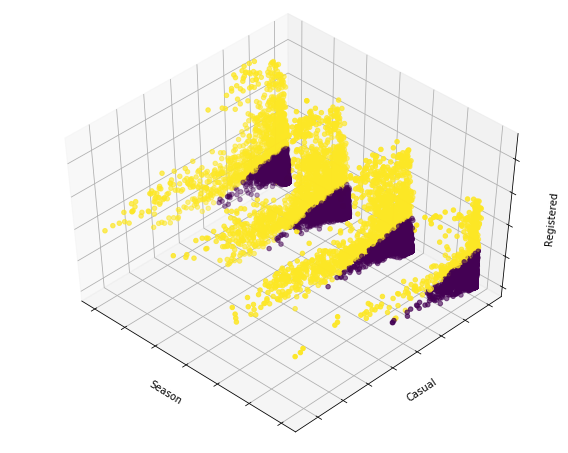

In [24]:
# representación 3D de los datos 
kmeans_2 = KMeans(n_clusters=2,init='k-means++',max_iter=MAX_ITERATIONS)
kmeans_bike = kmeans_2.fit(x)

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

labels = kmeans_bike.labels_

# vamos a representar 3 atributos en cada eje
ax.scatter(df_bike_vars.iloc[:, 0], df_bike_vars.iloc[:, 11], df_bike_vars.iloc[:, 15], c=labels.astype(np.float))

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Season')
ax.set_ylabel('Casual')
ax.set_zlabel('Registered')

plt.show()

In [25]:
# con el resultado de aplicar kmeans con 2 clusters obtenemos el atributo cluster
bikes = kmeans_2.fit_predict(x)
bikes

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [26]:
# añadimos el atributo que identifica a cada registro en uno de los clusters
df_bike["Cluster"] = bikes
df_bike.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,registered,cnt_class,Cluster
0,1,0,1,0,0,6,0,1,0.24,0.81,0.0,3,16,1,1,13.0,0,0
1,1,0,1,1,0,6,0,1,0.22,0.80,0.0,8,40,1,1,32.0,0,0
2,1,0,1,2,0,6,0,1,0.22,0.80,0.0,5,32,1,1,27.0,0,0
3,1,0,1,3,0,6,0,1,0.24,0.75,0.0,3,13,1,1,10.0,0,0
4,1,0,1,4,0,6,0,1,0.24,0.75,0.0,0,1,1,1,1.0,0,0


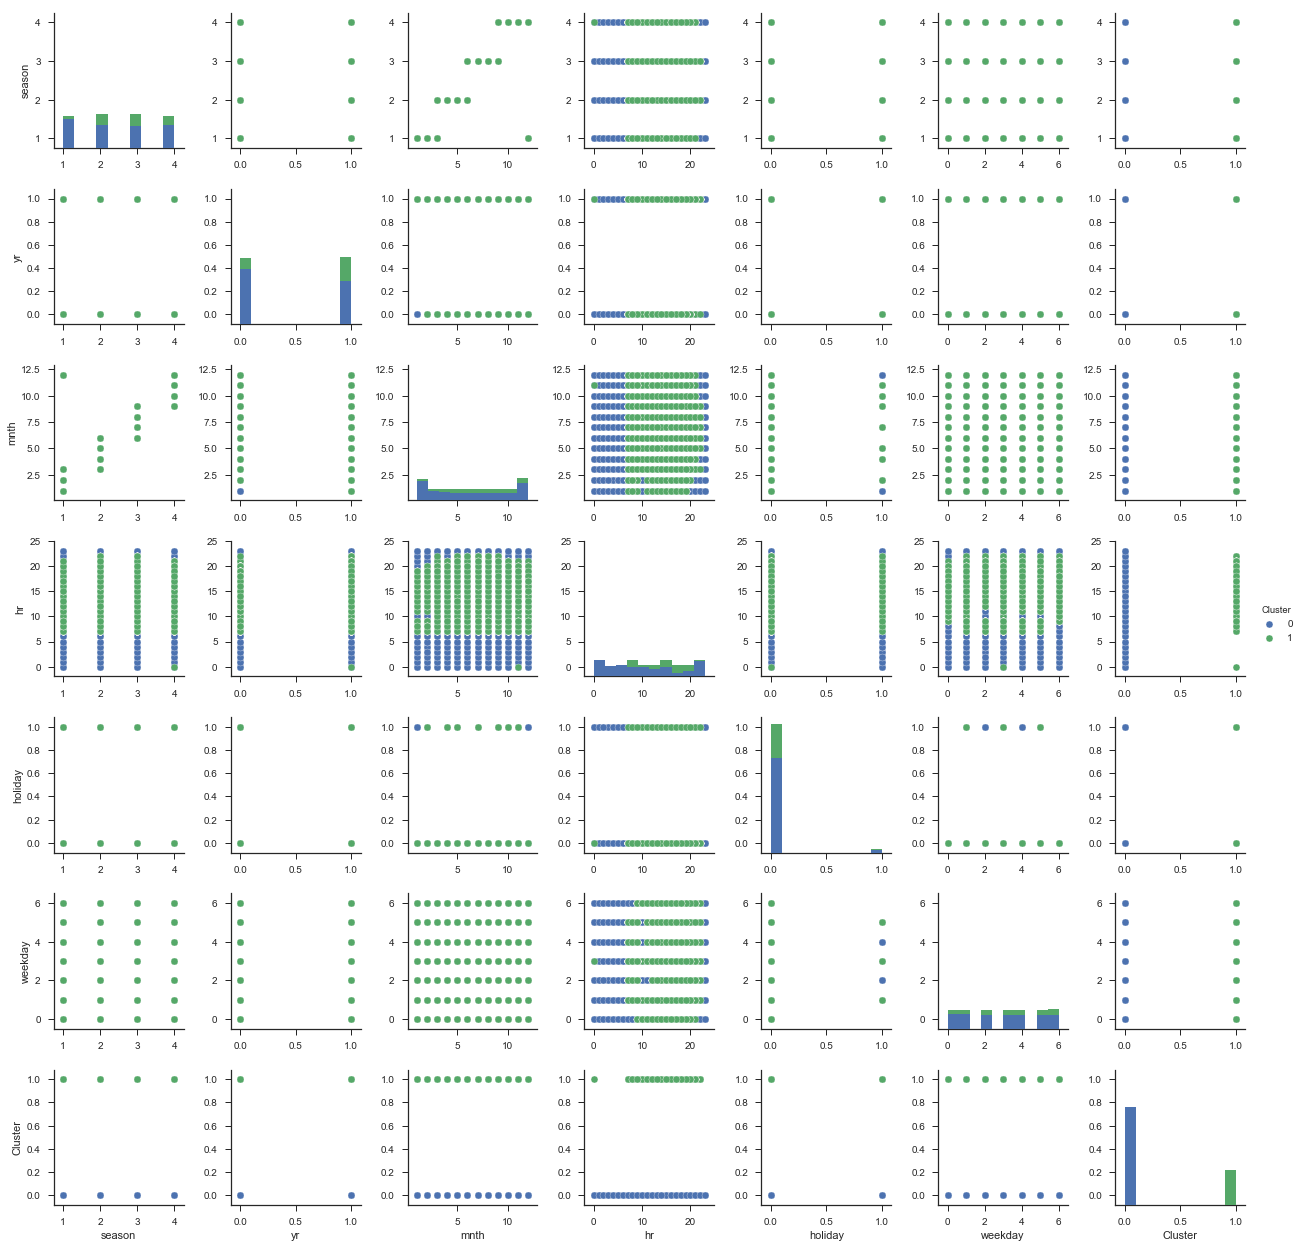

In [27]:
# graficamos los datos del dataset donde se aprecia para cada cluster con un color diferente
sns.set(style="ticks")

vars_uno = df_bike.columns[ : 6]
vars_dos = df_bike.columns[6 : 12]
vars_tres = df_bike.columns[12 : -1]
target_bike = df_bike.columns[-1]

sns.pairplot( df_bike[ list(vars_uno) + [target_bike] ], hue="Cluster" )

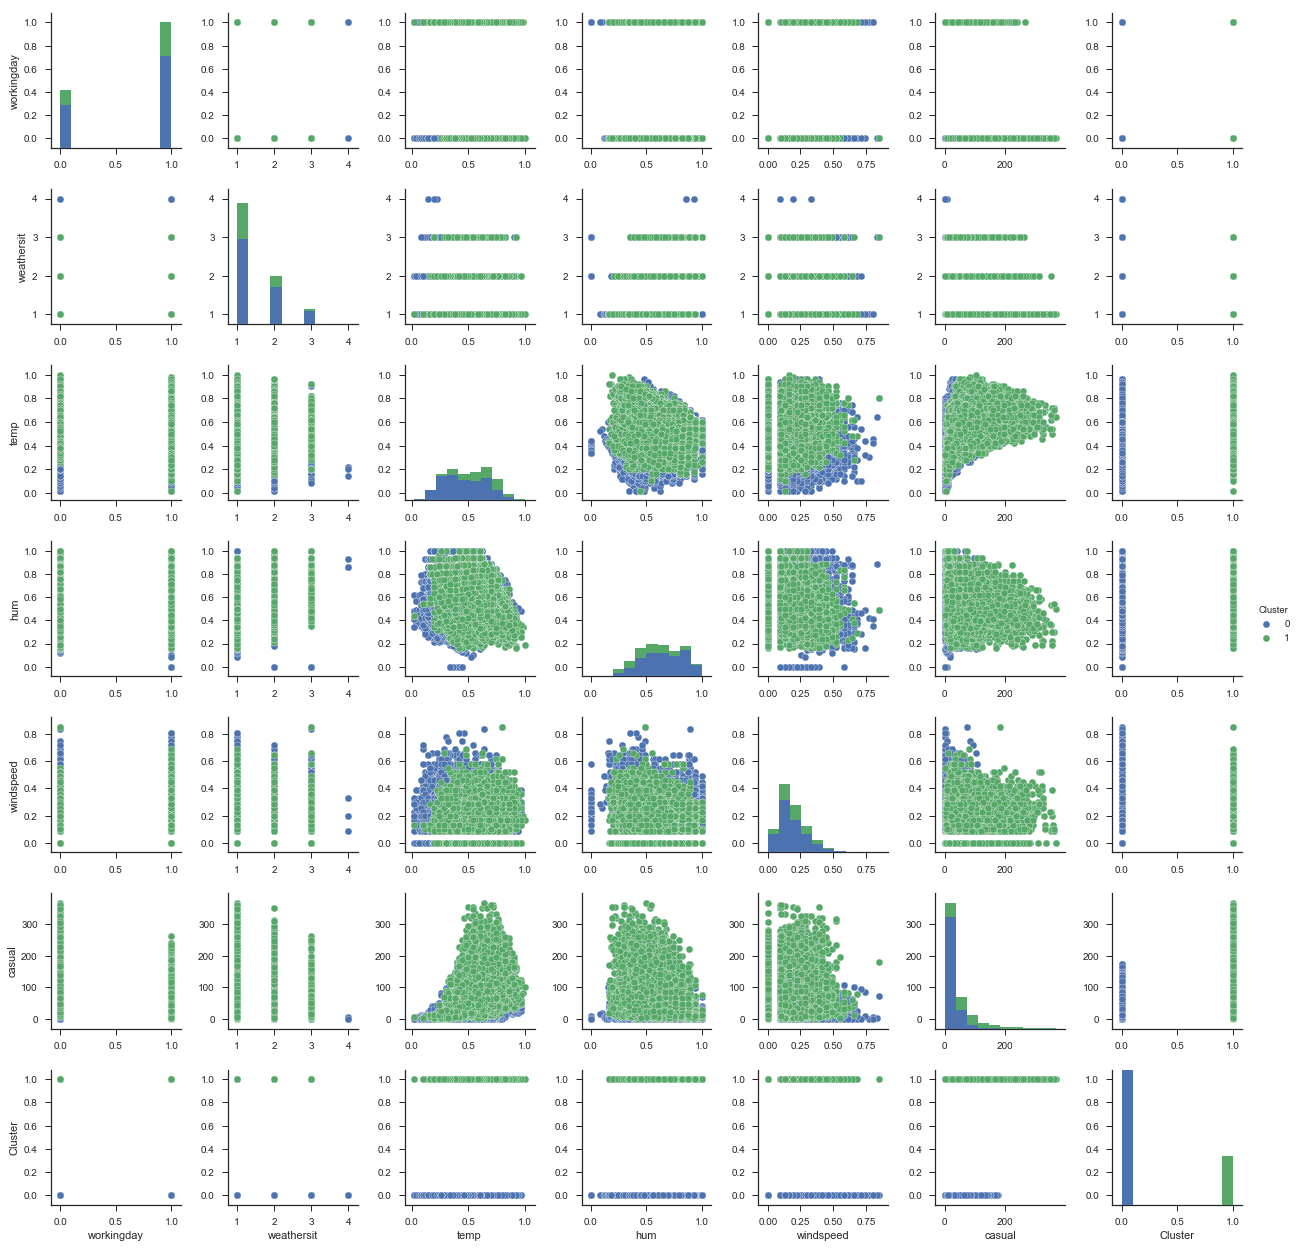

In [28]:
sns.pairplot( df_bike[ list(vars_dos) + [target_bike] ], hue="Cluster" )

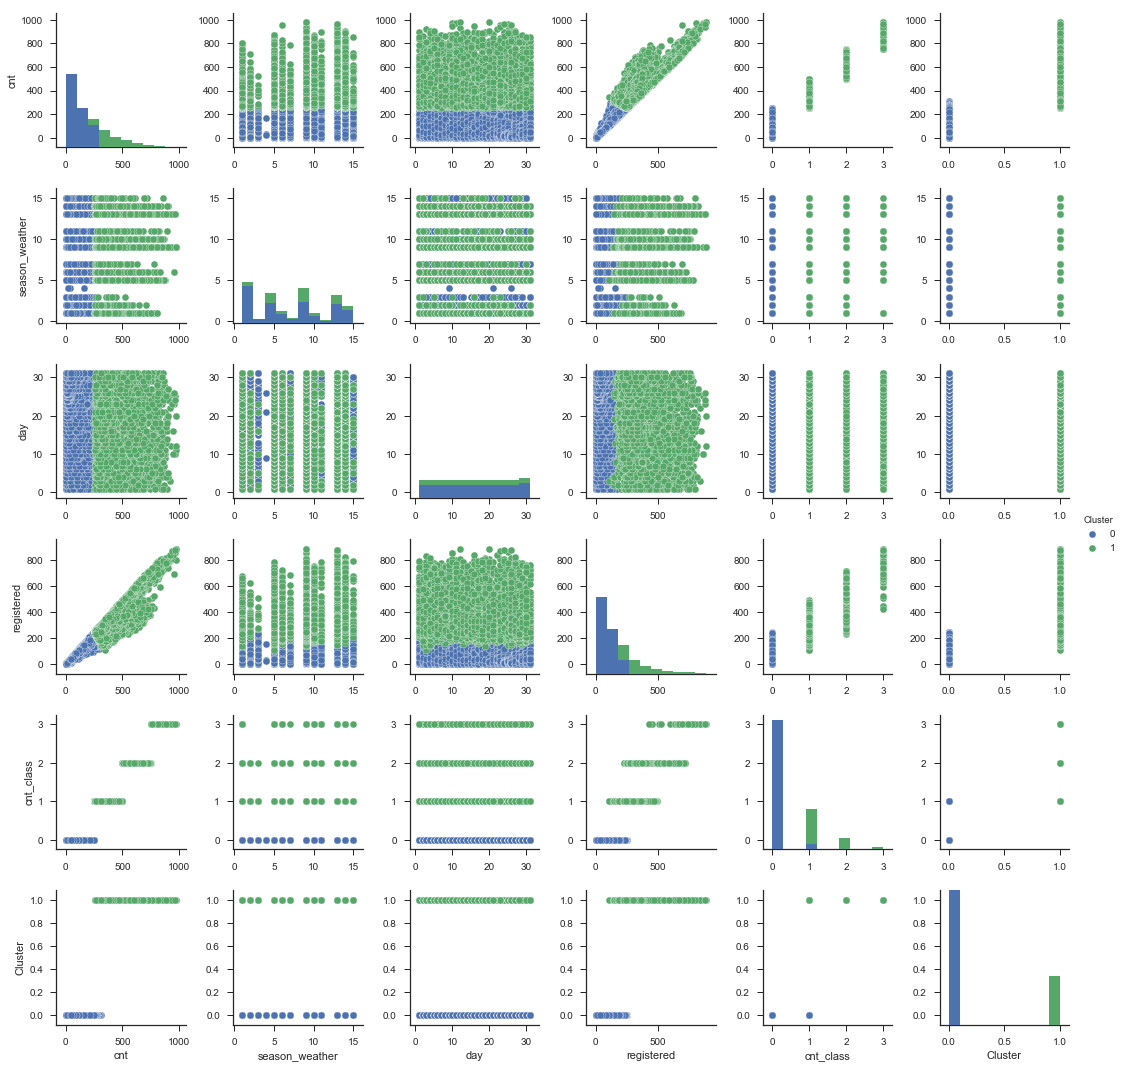

In [29]:
sns.pairplot( df_bike[ list(vars_tres) + [target_bike] ], hue="Cluster" )

In [30]:
# ver los registros de cada cluster
pd.value_counts(df_bike['Cluster'])

0    12776
1     4603
Name: Cluster, dtype: int64

In [31]:
# dataframe con los registros del cluster 0. Describe para primer análisis de estos registros.
df_bike_0 = df_bike[df_bike['Cluster']==0]
df_bike_0.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,registered,cnt_class,Cluster
count,12776.000000,12776.000000,12776.000000,12776.000000,12776.000000,12776.000000,12776.000000,12776.000000,12776.000000,12776.000000,12776.000000,12776.000000,12776.000000,12776.000000,12776.000000,12776.000000,12776.000000,12776.0
mean,2.397464,0.438791,6.319192,10.499217,0.030448,2.981058,0.680808,1.471039,0.458128,0.655704,0.185804,18.031857,99.577254,7.060895,15.728554,81.545398,0.038275,0.0
std,1.145729,0.496259,3.618309,7.377036,0.171822,2.006748,0.466182,0.669216,0.187326,0.190530,0.124229,22.482842,80.825650,4.626112,8.807312,65.315838,0.191867,0.0
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.0
25%,1.000000,0.000000,3.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.300000,0.510000,0.104500,2.000000,23.000000,2.000000,8.000000,19.000000,0.000000,0.0
50%,2.000000,0.000000,6.000000,10.000000,0.000000,3.000000,1.000000,1.000000,0.440000,0.660000,0.164200,9.000000,85.000000,6.000000,16.000000,71.000000,0.000000,0.0
75%,3.000000,1.000000,10.000000,17.000000,0.000000,5.000000,1.000000,2.000000,0.620000,0.820000,0.253700,27.000000,166.000000,11.000000,23.000000,134.000000,0.000000,0.0
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,0.960000,1.000000,0.850700,175.000000,308.000000,15.000000,31.000000,247.000000,1.000000,0.0


In [32]:
# dataframe con los registros del cluster 1. Describe para primer análisis de estos registros.
df_bike_1 = df_bike[df_bike['Cluster']==1]
df_bike_1.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,registered,cnt_class,Cluster
count,4603.000000,4603.000000,4603.000000,4603.000000,4603.000000,4603.000000,4603.000000,4603.000000,4603.000000,4603.000000,4603.000000,4603.000000,4603.000000,4603.000000,4603.000000,4603.000000,4603.000000,4603.0
mean,2.790789,0.679557,7.144471,14.454269,0.024115,3.066478,0.688030,1.298284,0.604845,0.548192,0.202016,84.649576,438.948512,8.461438,15.558114,354.298935,1.326526,1.0
std,0.932247,0.466698,2.794611,4.238365,0.153422,2.001936,0.463348,0.527690,0.163627,0.176878,0.116123,67.182275,146.357788,3.796311,8.739123,141.293085,0.560203,0.0
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.160000,0.000000,0.000000,256.000000,1.000000,1.000000,109.000000,1.000000,1.0
25%,2.000000,0.000000,5.000000,11.000000,0.000000,1.000000,0.000000,1.000000,0.500000,0.410000,0.134300,33.000000,322.000000,5.000000,8.000000,251.000000,1.000000,1.0
50%,3.000000,1.000000,7.000000,16.000000,0.000000,3.000000,1.000000,1.000000,0.620000,0.540000,0.194000,68.000000,398.000000,9.000000,15.000000,312.000000,1.000000,1.0
75%,4.000000,1.000000,9.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.740000,0.680000,0.283600,114.000000,518.000000,13.000000,23.000000,418.000000,2.000000,1.0
max,4.000000,1.000000,12.000000,22.000000,1.000000,6.000000,1.000000,3.000000,1.000000,1.000000,0.850700,367.000000,977.000000,15.000000,31.000000,886.000000,3.000000,1.0


#### Comentarios:

A continuación vamos a analizar la representación gráfica mediante scatter plot de los datos diferenciados por cluster y las medidas estadísticas obtenidas con el uso de describe(), con el principal objetivo de sacar conclusiones respecto a cómo k-means ha separado los datos en dos clusters:

Claramente podemos apreciar que el cluster 0, tiene aproximadamente el triple de registros que el cluster catalogado como 1. Tambien podemos ver, como las variables casual, cnt y registered es donde encontramos las mayores diferencias a nivel estadístico, pues la medias de estos atributos en el cluster 0 son mucho menores a las obtenidas en el cluster 1. Por otro lado nos encontramos un cluster con más registros y un uso pequeño y moderado del servicio de bicis, y otro con menor número y un uso muy alto. Y es el cluster que tiene mayor uso el que está ligado a mejores condiciones climatológicas, aspecto que se puede apreciar en los datos estadísticos de las variables temperatura y humedad. 

Por todo lo expuesto podemos inferir que lo que más ha influido en la separación en los 2 clusters es el uso del servicio de bicicletas reflejado en las varaibles analizadas. 

In [33]:
# normalizar los datos
df_normalizado = (df_bike - df_bike.mean()) / df_bike.std()

df_bike_vars_n = df_normalizado[vars_bike]
df_bike_target_n = df_normalizado[target_bike]

LOOPS = 20
MAX_ITERATIONS = 30
INITIALIZE_CLUSTERS = 'k-means++'
CONVERGENCE_TOLERANCE = 0.001
NUM_THREADS = 8

x_n = df_bike_vars_n
y_n = df_bike_target_n

In [34]:
kmeans_2_n = KMeans(n_clusters=2,init='k-means++',max_iter=MAX_ITERATIONS)
kmeans_bike_n = kmeans_2_n.fit(x_n)

In [35]:
# con el resultado de aplicar kmeans con 2 clusters obtenemos el atributo cluster
bikes_n = kmeans_2_n.fit_predict(x_n)
bikes_n

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [36]:
# añadimos el atributo que identifica a cada registro en uno de los clusters
df_bike_n = df_bike
df_bike_n["Cluster"] = bikes_n
df_bike_n.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,registered,cnt_class,Cluster
0,1,0,1,0,0,6,0,1,0.24,0.81,0.0,3,16,1,1,13.0,0,0
1,1,0,1,1,0,6,0,1,0.22,0.80,0.0,8,40,1,1,32.0,0,0
2,1,0,1,2,0,6,0,1,0.22,0.80,0.0,5,32,1,1,27.0,0,0
3,1,0,1,3,0,6,0,1,0.24,0.75,0.0,3,13,1,1,10.0,0,0
4,1,0,1,4,0,6,0,1,0.24,0.75,0.0,0,1,1,1,1.0,0,0


In [37]:
# ver los registros de cada cluster
pd.value_counts(df_bike_n['Cluster'])

1    10318
0     7061
Name: Cluster, dtype: int64

In [38]:
# dataframe con los registros del cluster 0. Describe para primer análisis de estos registros.
df_bike_0_n = df_bike_n[df_bike_n['Cluster']==0]
df_bike_0_n.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,registered,cnt_class,Cluster
count,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.0
mean,1.402776,0.479677,3.637445,10.788415,0.031440,2.985979,0.682198,1.490440,0.373364,0.619783,0.210886,15.795072,105.409007,3.101544,15.864042,89.613936,0.103385,0.0
std,0.490491,0.499622,2.776823,7.157277,0.174517,2.008185,0.465655,0.675618,0.150096,0.206053,0.130544,22.917238,104.045337,2.108132,8.835749,91.576100,0.330792,0.0
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.0
25%,1.000000,0.000000,2.000000,5.000000,0.000000,1.000000,0.000000,1.000000,0.260000,0.460000,0.104500,2.000000,22.000000,1.000000,8.000000,19.000000,0.000000,0.0
50%,1.000000,0.000000,3.000000,10.000000,0.000000,3.000000,1.000000,1.000000,0.360000,0.610000,0.194000,7.000000,77.000000,2.000000,16.000000,65.000000,0.000000,0.0
75%,2.000000,1.000000,4.000000,17.000000,0.000000,5.000000,1.000000,2.000000,0.500000,0.800000,0.283600,20.000000,159.000000,5.000000,24.000000,130.000000,0.000000,0.0
max,2.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,0.860000,1.000000,0.806000,229.000000,662.000000,7.000000,31.000000,628.000000,2.000000,0.0


In [39]:
# dataframe con los registros del cluster 1. Describe para primer análisis de estos registros.
df_bike_1_n = df_bike_n[df_bike_n['Cluster']==1]
df_bike_1_n.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,registered,cnt_class,Cluster
count,10318.000000,10318.000000,10318.000000,10318.000000,10318.000000,10318.000000,10318.000000,10318.000000,10318.000000,10318.000000,10318.000000,10318.000000,10318.000000,10318.000000,10318.000000,10318.000000,10318.000000,10318.0
mean,3.253634,0.518221,8.522582,12.065710,0.026943,3.015798,0.683078,1.380694,0.581588,0.632324,0.175872,49.281644,246.984493,10.395232,15.559798,197.702849,0.568424,1.0
std,0.712211,0.499692,2.223707,6.694177,0.161925,2.004125,0.465299,0.609339,0.171523,0.183245,0.114240,57.268859,199.667301,2.985673,8.755777,167.636659,0.753088,0.0
min,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.140000,0.160000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.0
25%,3.000000,0.000000,7.000000,7.000000,0.000000,1.000000,0.000000,1.000000,0.440000,0.490000,0.104500,8.000000,80.000000,9.000000,8.000000,68.000000,0.000000,1.0
50%,3.000000,1.000000,9.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.620000,0.640000,0.164200,30.000000,212.000000,10.000000,16.000000,167.000000,0.000000,1.0
75%,4.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.720000,0.780000,0.253700,68.000000,365.000000,13.000000,23.000000,275.000000,1.000000,1.0
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,3.000000,1.000000,1.000000,0.850700,367.000000,977.000000,15.000000,31.000000,886.000000,3.000000,1.0


#### Comentarios
Al normalizar las variables y volver a aplicar k-means vemos como la separación en 2 clusters arroja unos clusters algo más igualados en número a la anterior prueba realizada. Suponemos que esto es debido a que algunos atributos tienen menos peso que antes e influyen algo menos a la hora de separar los datos.